Dataset shape: (20634, 9)

Dataset Size Information:
Index                    128
MedInc                165072
HouseAge              165072
AveRooms              165072
AveBedrms             165072
Population            165072
AveOccup              165072
Latitude              165072
Longitude             165072
price_above_median    165072
dtype: int64
Total Memory Usage: 1.42 MB

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20634 entries, 0 to 20633
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MedInc              20634 non-null  float64
 1   HouseAge            20634 non-null  float64
 2   AveRooms            20634 non-null  float64
 3   AveBedrms           20634 non-null  float64
 4   Population          20634 non-null  float64
 5   AveOccup            20634 non-null  float64
 6   Latitude            20634 non-null  float64
 7   Longitude           20634 non-null  floa

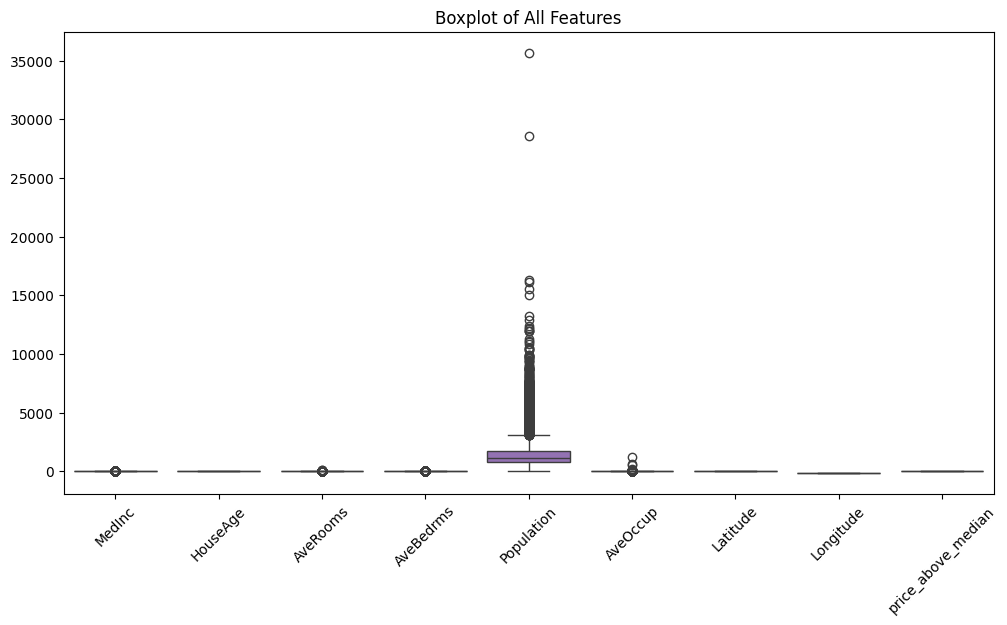

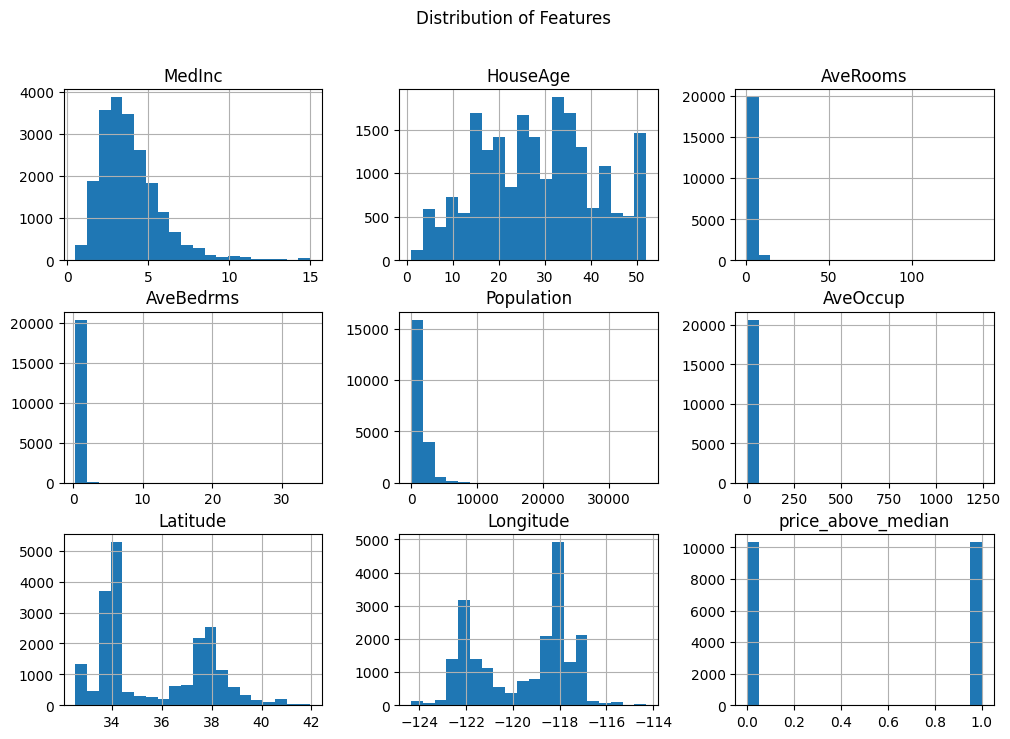

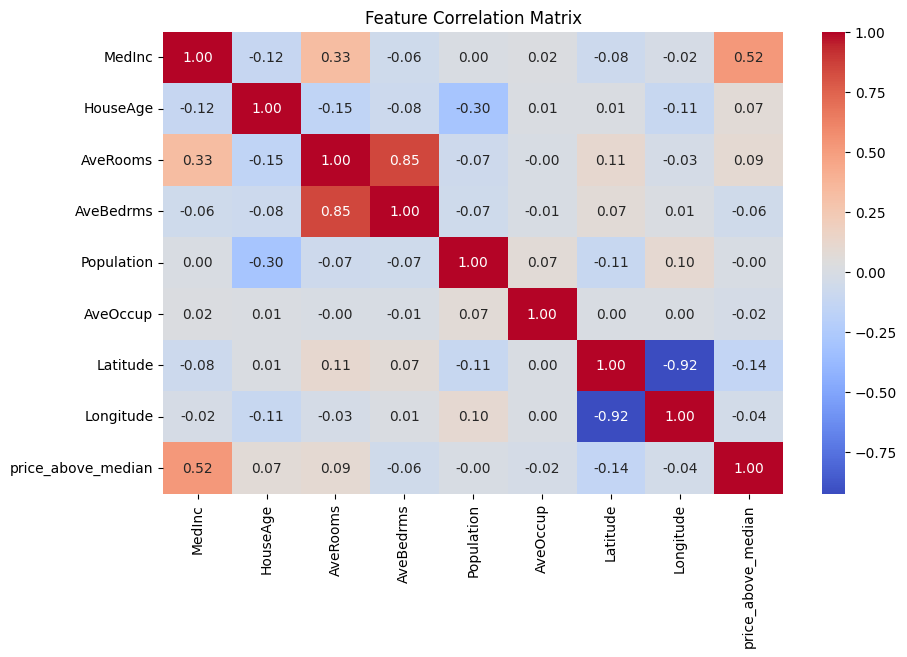


Training set shape: (16507, 8)
Test set shape: (4127, 8)

Training KNN...

KNN - Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2064
           1       0.82      0.84      0.83      2063

    accuracy                           0.83      4127
   macro avg       0.83      0.83      0.83      4127
weighted avg       0.83      0.83      0.83      4127



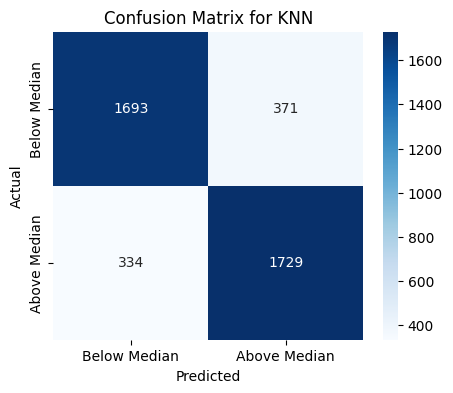


Training Decision Tree...

Decision Tree - Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      2064
           1       0.83      0.87      0.85      2063

    accuracy                           0.85      4127
   macro avg       0.85      0.85      0.85      4127
weighted avg       0.85      0.85      0.85      4127



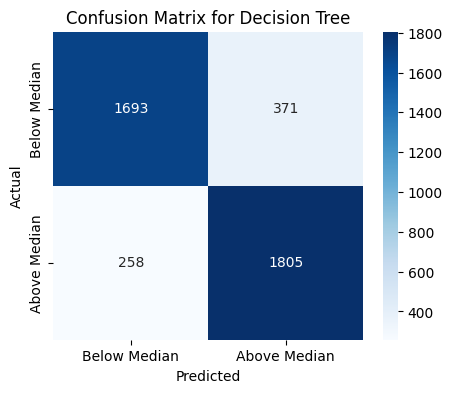


Training Random Forest...

Random Forest - Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2064
           1       0.88      0.89      0.89      2063

    accuracy                           0.89      4127
   macro avg       0.89      0.89      0.89      4127
weighted avg       0.89      0.89      0.89      4127



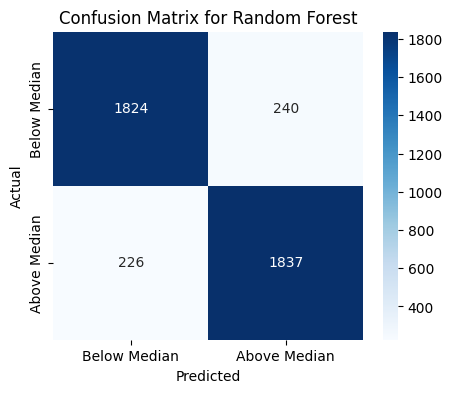


Training AdaBoost...

AdaBoost - Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2064
           1       0.86      0.89      0.87      2063

    accuracy                           0.87      4127
   macro avg       0.87      0.87      0.87      4127
weighted avg       0.87      0.87      0.87      4127



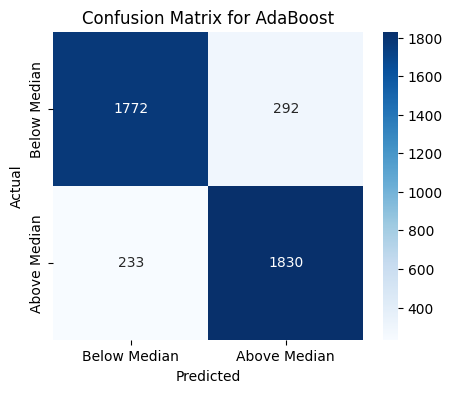

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

# shape & size
df = pd.read_csv("california_housing.csv")  # Ensure the file is in your working directory

# shape and memory usage
print("Dataset shape:", df.shape)
print("\nDataset Size Information:")
print(df.memory_usage(deep=True))  # Shows memory usage per column
print("Total Memory Usage: {:.2f} MB".format(df.memory_usage(deep=True).sum() / (1024**2)))

# inspect data types & and handle duplicates
print("\nDataset Information:")
print(df.info())

numeric_cols = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"]
for col in numeric_cols:
    if not np.issubdtype(df[col].dtype, np.number):
        print(f" WARNING: Column '{col}' is not numeric! Attempting conversion...")
        df[col] = pd.to_numeric(df[col], errors='coerce')

if df["price_above_median"].dtype != "int64":
    print(" Converting target variable 'price_above_median' to integer type.")
    df["price_above_median"] = df["price_above_median"].astype(int)

print("\n All necessary datatype conversions are complete!")

# remove duplicate rows
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print("Dataset shape after removing duplicates:", df.shape)

print("\nStatistical Summary:")
print(df.describe())

# identify anomalies 
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Boxplot of All Features")
plt.xticks(rotation=45)
plt.show()

# Univariate Analysis & Visualization

# histogram of numerical features
df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Distribution of Features")
plt.show()

# correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# data preprocessing 
# ensure the target variable is binary (1: Above Median, 0: Below Median)
df['price_above_median'] = df['price_above_median'].astype(int)

X = df.drop(columns=['price_above_median'])
y = df['price_above_median']

# standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


# define models
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# define hyperparameter grid for tuning
param_grids = {
    "KNN": {"n_neighbors": [3, 5, 7]},
    "Decision Tree": {"max_depth": [5, 10, 15]},
    "Random Forest": {"n_estimators": [50, 100, 150]},
    "AdaBoost": {"n_estimators": [50, 100, 150]}
}

# train models, tune hyperparameters, and evaluate performance
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    if model_name in param_grids:
        grid_search = GridSearchCV(model, param_grids[model_name], cv=5)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model.fit(X_train, y_train)

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    print(f"\n{model_name} - Classification Report (Test Data):")
    print(classification_report(y_test, y_pred_test))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Below Median", "Above Median"],
                yticklabels=["Below Median", "Above Median"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
